In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/optuna/study/_optimize.py:29: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from optuna import progress_bar as pbar_module


In [2]:
data_dir = "/lustre/groups/ml01/workspace/cell_flow_zebrafish/results/single_condition/cell_type_proportion"
output_dir = "/lustre/groups/ml01/workspace/cell_flow_zebrafish/results/single_condition/cell_type_proportion_downstream"

In [3]:

adata = sc.read_h5ad("/lustre/groups/ml01/workspace/ot_perturbation/data/zebrafish_new/zebrafish_processed.h5ad")

In [4]:
df_counts = adata.obs.groupby(["condition","cell_type_broad"]).size().to_frame(name="n_cells")


/tmp/ipykernel_3981988/2853154197.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_counts = adata.obs.groupby(["condition","cell_type_broad"]).size().to_frame(name="n_cells")


In [5]:
df_counts = df_counts.reset_index()

In [6]:
ood_conditions = ['zc4h2_control_24','met_control_36','tfap2a_control_72','hgfa_control_48','tfap2a_foxd3_72','noto_control_18','cdx4_cdx1a_36','epha4a_control_48','mafba_control_36','tbx16_msgn1_24','noto_control_24','smo_control_18','hand2_control_24','noto_control_36','egr2b_control_36','cdx4_control_18','tfap2a_control_36','foxi1_control_72','egr2b_control_24','cdx4_control_36','zc4h2_control_36','hoxb1a_control_48','tfap2a_foxd3_36','tbx16_tbx16l_24','smo_control_36','mafba_control_18','hgfa_control_72','tbx16_control_18','mafba_control_24','tbx1_control_36','zc4h2_control_48','wnt3a_wnt8_36','foxi1_control_48','smo_control_24','noto_control_48','mafba_control_48','tfap2a_control_48','hand2_control_48','egr2b_control_48','phox2a_control_48','tbx1_control_48','tbx16_msgn1_36','foxd3_control_72','wnt3a_wnt8_24','egr2b_control_18','wnt3a_wnt8_18','met_control_72','phox2a_control_36','epha4a_control_24','foxd3_control_36','tfap2a_foxd3_48','hand2_control_36','cdx4_cdx1a_24','hgfa_control_36','tbx16_tbx16l_18','tbxta_control_36','cdx4_control_24','foxd3_control_48','met_control_48','tbx1_control_24','epha4a_control_36','cdx4_cdx1a_18','tbx16_control_36','tbx16_tbx16l_36','tbx16_control_24','tbxta_control_24','tbx16_msgn1_18','epha4a_control_18','tbxta_control_18','hoxb1a_control_36','hoxb1a_control_24']
      

In [7]:
spearman_corrs = {}
pearson_corrs = {}
max_logratios = {}
dfs = []
for ood_cond in ood_conditions:
    csv_file = [el for el in os.listdir(data_dir) if ((ood_cond in el) and ("csv" in el))]
    if len(csv_file)==0:
        continue
    assert len(csv_file) == 1
    df = pd.read_csv(os.path.join(data_dir, csv_file[0]))
    spearman_corrs[ood_cond] = df[["logratio_true", "logratio_pred"]].corr("spearman").iloc[0,1]
    pearson_corrs[ood_cond] = df[["logratio_true", "logratio_pred"]].corr("pearson").iloc[0,1]
    max_logratios[ood_cond] = np.abs(df["logratio_true"]).max()
    df["condition"] = f"{ood_cond}"
    dfs.append(df)

In [8]:
df_pred = pd.concat(dfs)
df_pred["gene_target"] = df_pred.apply(lambda x: "_".join(x["condition"].split("_")[:2]), axis=1)
df_pred["timepoint"] = df_pred.apply(lambda x: int(x["condition"].split("_")[-1]), axis=1)

In [9]:
df_pred.head()

,cell_type_broad_transfer,ratio_pred,ratio_true,logratio_true,logratio_pred,condition,gene_target,timepoint
0,periderm,1.182168,1.349712,0.432652,0.241436,zc4h2_control_24,zc4h2_control,24
1,mature fast muscle,1.177825,1.242196,0.312892,0.236125,zc4h2_control_24,zc4h2_control,24
2,connective tissue-meninges-dermal FB,1.046386,0.899433,-0.152912,0.065415,zc4h2_control_24,zc4h2_control,24
3,neural progenitor (hindbrain),0.864279,0.775667,-0.366491,-0.210431,zc4h2_control_24,zc4h2_control,24
4,mature slow muscle,0.975546,1.205383,0.269492,-0.035718,zc4h2_control_24,zc4h2_control,24


In [10]:
df_baseline = pd.read_csv("/lustre/groups/ml01/workspace/cell_flow_zebrafish/results/single_condition/cell_type_proportion_baseline/all_single_oligo_ratios.csv", index_col=0)


In [11]:
df_baseline["cell_type_broad_transfer"] = df_baseline.index
df_baseline = df_baseline.rename(columns={"logratio_oligo": "logratio_pred", "ratio_olgo": "logratio_pred"})
df_baseline["mode"] = "single_oligo"
df_pred["mode"] = "CellFlow"

In [12]:
df_concat = pd.concat((df_baseline,df_pred))

In [13]:
df_counts.head()

,condition,cell_type_broad,n_cells
0,cdx4_cdx1a_18,KA neuron,4
1,cdx4_cdx1a_18,adrenal gland,0
2,cdx4_cdx1a_18,anterior migratory muscle,302
3,cdx4_cdx1a_18,basal cell,1
4,cdx4_cdx1a_18,cardiomyocyte,76


# Given one cell type, how good are we at ranking the conditions?

In [66]:
df_corrs_conditions = pd.DataFrame(columns=["cell_type_broad", "pearson", "spearman", "method", "n_cells_mean", "n_cells_var"])

i=0


for cell_type in adata.obs["cell_type_broad"].unique():
    df_pred_red = df_pred[(df_pred["cell_type_broad_transfer"]==cell_type) & (df_pred["gene_target"]!="control_control")]
    df_baseline_red = df_baseline[(df_baseline["cell_type_broad_transfer"]==cell_type) & (df_baseline["gene_target"]!="control_control")]
    pearson_pred = df_pred_red[["logratio_true", "logratio_pred"]].corr(method="pearson").iloc[0,1]
    pearson_baseline = df_baseline_red[["logratio_true", "logratio_pred"]].corr(method="pearson").iloc[0,1]
    spearman_pred = df_pred_red[["logratio_true", "logratio_pred"]].corr(method="spearman").iloc[0,1]
    spearman_baseline = df_baseline_red[["logratio_true", "logratio_pred"]].corr(method="spearman").iloc[0,1]
    n_cells_mean = df_counts[df_counts["cell_type_broad"]==cell_type]["n_cells"].mean()
    n_cells_var = df_counts[df_counts["cell_type_broad"]==cell_type]["n_cells"].std()
    df_corrs_conditions.loc[len(df_corrs_conditions)] = [cell_type, pearson_pred, spearman_pred, "cellflow", n_cells_mean, n_cells_var]
    df_corrs_conditions.loc[len(df_corrs_conditions)] = [cell_type, pearson_baseline, spearman_baseline, "single_oligo", n_cells_mean, n_cells_var]
    i+=2

    

In [67]:
df_ranks = pd.DataFrame(columns=["cell_type_broad", "method", "n_cells_mean", "n_cells_var", "top_1", "top_3", "top_5", "top_10", "top_30"])

i=0


for cell_type in adata.obs["cell_type_broad"].unique():
    df_pred_red = df_pred[(df_pred["cell_type_broad_transfer"]==cell_type) & (df_pred["gene_target"]!="control_control")]
    df_baseline_red = df_baseline[(df_baseline["cell_type_broad_transfer"]==cell_type) & (df_baseline["gene_target"]!="control_control")]
    true_ranking = df_pred_red.sort_values("logratio_true")["condition"].values
    pred_ranking = df_pred_red.sort_values("logratio_pred")["condition"].values
    baseline_ranking = df_baseline_red.sort_values("logratio_pred")["condition"].values
    baseline_intersection = []
    pred_intersection = []
    for j in [1,3,5,10,30]:
        baseline_intersection+=[len(set(true_ranking[:j]).intersection(set(list(dict.fromkeys(baseline_ranking))[:j])))/j]
        pred_intersection += [len(set(true_ranking[:j]).intersection(set(pred_ranking[:j])))/j]
    n_cells_mean = df_counts[df_counts["cell_type_broad"]==cell_type]["n_cells"].mean()
    n_cells_var = df_counts[df_counts["cell_type_broad"]==cell_type]["n_cells"].std()
    df_ranks.loc[len(df_ranks)] = [cell_type, "cellflow", n_cells_mean, n_cells_var] + pred_intersection
    df_ranks.loc[len(df_ranks)] = [cell_type, "single_oligo", n_cells_mean, n_cells_var] + baseline_intersection
    i+=2

    



In [68]:
df_long = df_ranks.melt(
    id_vars=["cell_type_broad", "method", "n_cells_mean", "n_cells_var"],
    value_vars=["top_1", "top_3", "top_5", "top_10", "top_30"],
    var_name="top",
    value_name="rank"
)

<Axes: xlabel='method', ylabel='rank'>

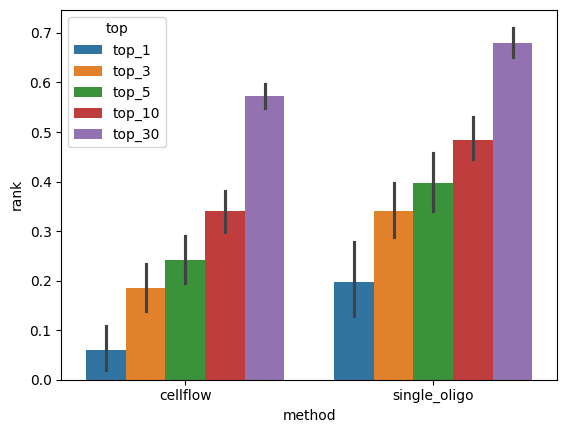

In [69]:
sns.barplot(df_long, y="rank", x="method", hue="top")

In [70]:
df_corrs_conditions["cell_type_size"] = pd.qcut(df_corrs_conditions["n_cells_mean"], q=5, labels=[1, 2, 3, 4, 5])


<Axes: xlabel='cell_type_size', ylabel='pearson'>

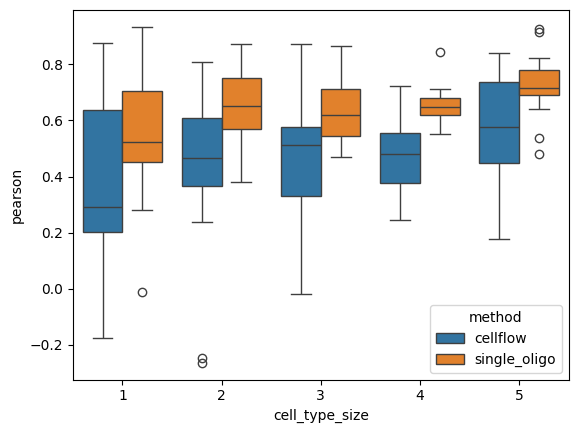

In [71]:
sns.boxplot(df_corrs_conditions, x="cell_type_size", y="pearson", hue="method")

<Axes: xlabel='method', ylabel='pearson'>

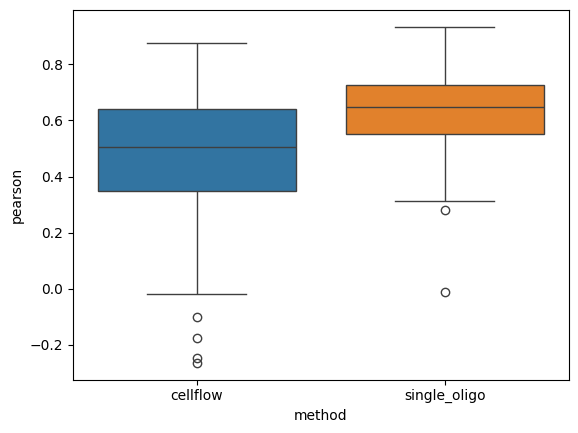

In [72]:
sns.boxplot(df_corrs_conditions, x="method", y="pearson", hue="method")

In [73]:
df_long[(df_long["top"]=="top_3") & (df_long["rank"]==1.0)].head()

,cell_type_broad,method,n_cells_mean,n_cells_var,top,rank
213,mature fast muscle,single_oligo,3144.302632,3400.120355,top_3,1.0
217,mature slow muscle,single_oligo,840.973684,794.108657,top_3,1.0
227,periderm,single_oligo,6254.986842,7716.934648,top_3,1.0
234,support cells/otic vesicle,cellflow,343.039474,289.189877,top_3,1.0
249,pectoral fin bud (osteoblast+),single_oligo,206.118421,208.430066,top_3,1.0


In [74]:
df_long.to_csv(os.path.join(output_dir, "top_k_rank.csv"))
df_corrs_conditions.to_csv(os.path.join(output_dir, "corrs_conditions.csv"))

In [75]:
cell_type = 'mature fast muscle'
df_concat_red = df_concat[df_concat["cell_type_broad_transfer"]==cell_type]

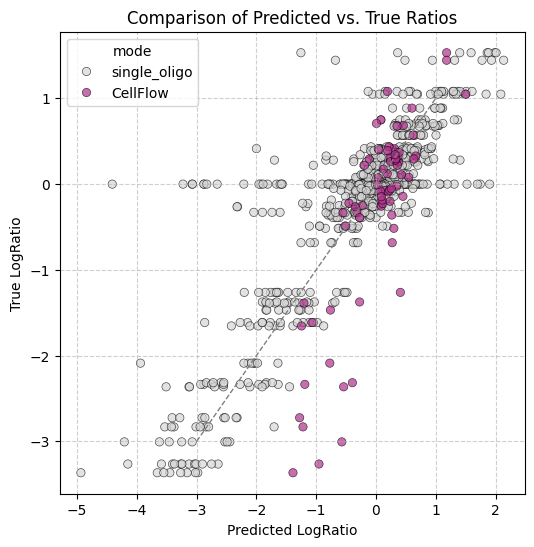

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

color_dict = {"CellFlow": "#B12F8C", "single_oligo": "#D6D6D6"}


# Scatter plot with seaborn
sns.scatterplot(data=df_concat_red, x="logratio_pred", y="logratio_true", hue="mode", alpha=0.7, edgecolor="k", palette=color_dict)

# Add a diagonal reference line (ideal y = x line)
plt.plot([-3, 1], [-3, 1], linestyle="--", color="gray", linewidth=1)

# Labels and title
plt.xlabel("Predicted LogRatio")
plt.ylabel("True LogRatio")
plt.title("Comparison of Predicted vs. True Ratios")

# Grid and styling
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()


In [77]:
df_concat_red[df_concat_red["mode"]=="CellFlow"][["logratio_true", "logratio_pred"]].corr("pearson").iloc[0,1]


0.8336044855121383

In [78]:
df_concat_red[df_concat_red["mode"]=="single_oligo"][["logratio_true", "logratio_pred"]].corr("pearson").iloc[0,1]

0.8594568620335532

In [79]:
cond_to_check1 = df_concat_red.sort_values("logratio_pred")["condition"].iloc[0]

In [80]:
cell_type_str = cell_type.replace(" ", "_")
df_concat_red.to_csv(os.path.join(output_dir, f"logfoldchanges_{cell_type_str}.csv"))

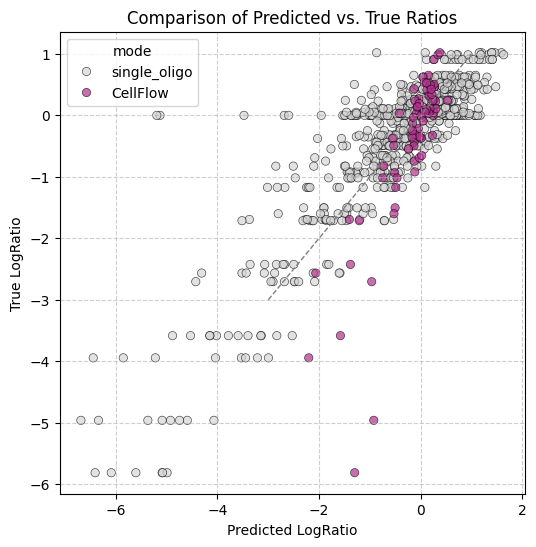

In [81]:
cell_type = 'mature slow muscle'
df_concat_red = df_concat[df_concat["cell_type_broad_transfer"]==cell_type]

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

color_dict = {"CellFlow": "#B12F8C", "single_oligo": "#D6D6D6"}


# Scatter plot with seaborn
sns.scatterplot(data=df_concat_red, x="logratio_pred", y="logratio_true", hue="mode", alpha=0.7, edgecolor="k", palette=color_dict)

# Add a diagonal reference line (ideal y = x line)
plt.plot([-3, 1], [-3, 1], linestyle="--", color="gray", linewidth=1)

# Labels and title
plt.xlabel("Predicted LogRatio")
plt.ylabel("True LogRatio")
plt.title("Comparison of Predicted vs. True Ratios")

# Grid and styling
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()


In [82]:
df_concat_red[df_concat_red["mode"]=="CellFlow"][["logratio_true", "logratio_pred"]].corr("pearson").iloc[0,1]


0.8394975807870989

In [83]:
df_concat_red[df_concat_red["mode"]=="single_oligo"][["logratio_true", "logratio_pred"]].corr("pearson").iloc[0,1]

0.8698406488008946

In [84]:
cell_type_str = cell_type.replace(" ", "_")
df_concat_red.to_csv(os.path.join(output_dir, f"logfoldchanges_{cell_type_str}.csv"))

In [85]:
cond_to_check2 = df_concat_red.sort_values("logratio_pred")["condition"].iloc[0]

# Given one condition, how good are we at predicting the effect on each cell type?

In [86]:
df_corrs_cts = pd.DataFrame(columns=["condition", "pearson", "spearman", "method", "n_oligos"])
i=0
for condition in adata.obs["condition"].unique():
    if "control_control" in condition:
        continue
    df_pred_red = df_pred[(df_pred["condition"]==condition)]
    df_baseline_red = df_baseline[(df_baseline["condition"]==condition)]
    pearson_pred = df_pred_red[["logratio_true", "logratio_pred"]].corr(method="pearson").iloc[0,1]
    pearson_baseline = df_baseline_red[["logratio_true", "logratio_pred"]].corr(method="pearson").iloc[0,1]
    spearman_pred = df_pred_red[["logratio_true", "logratio_pred"]].corr(method="spearman").iloc[0,1]
    spearman_baseline = df_baseline_red[["logratio_true", "logratio_pred"]].corr(method="spearman").iloc[0,1]
    n_oligos = df_baseline_red["Oligo"].nunique()
    df_corrs_cts.loc[len(df_corrs_cts)] = [condition, pearson_pred, spearman_pred, "cellflow", n_oligos]
    df_corrs_cts.loc[len(df_corrs_cts)] = [condition, pearson_baseline, spearman_baseline, "single_oligo", n_oligos]
    i+=2
    
    

In [87]:

df_corrs_cts.to_csv(os.path.join(output_dir, "corrs_cell_types.csv"))

<Axes: xlabel='method', ylabel='pearson'>

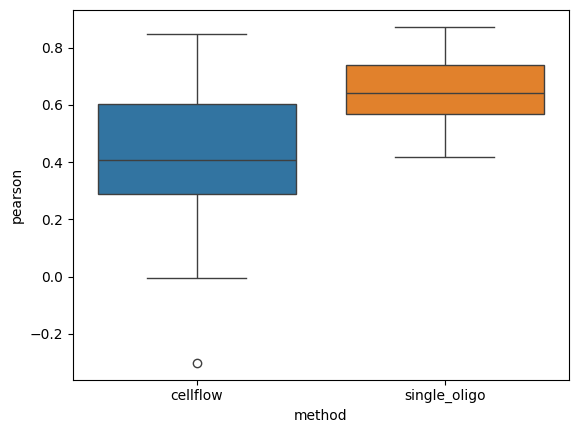

In [88]:
sns.boxplot(df_corrs_cts, x="method", y="pearson", hue="method")

<Axes: xlabel='n_oligos', ylabel='pearson'>

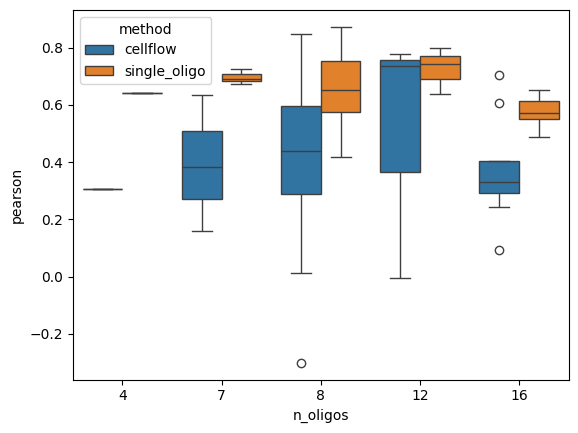

In [89]:
sns.boxplot(df_corrs_cts, x="n_oligos", y="pearson", hue="method")

In [90]:
df_corrs_cts["gene_target"] = df_corrs_cts.apply(lambda x: "_".join(x["condition"].split("_")[:2]), axis=1)
df_corrs_cts["timepoint"] = df_corrs_cts.apply(lambda x: int(x["condition"].split("_")[-1]), axis=1)

<Axes: xlabel='timepoint', ylabel='pearson'>

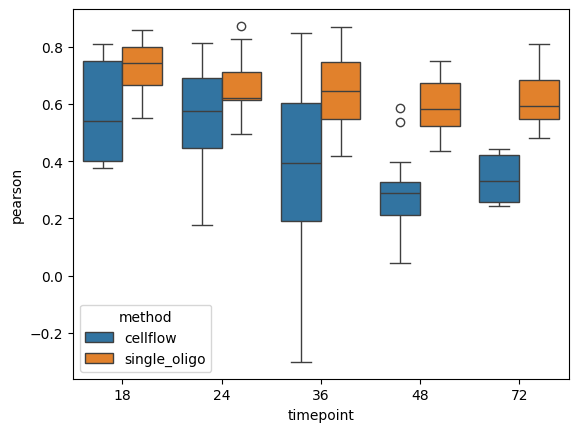

In [91]:
sns.boxplot(df_corrs_cts, x="timepoint", y="pearson", hue="method")

In [93]:
cond =cond_to_check1
df_concat_red = df_concat[df_concat["condition"]==cond]

df_concat_red["n_cells"] = df_concat_red.apply(lambda x: np.log(df_counts[(df_counts["condition"]==x["condition"])&(df_counts["cell_type_broad"]==x["cell_type_broad_transfer"])]["n_cells"].values[0]+1), axis=1)
df_concat_red = df_concat_red.reset_index()

/tmp/ipykernel_3981988/3531241947.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_concat_red["n_cells"] = df_concat_red.apply(lambda x: np.log(df_counts[(df_counts["condition"]==x["condition"])&(df_counts["cell_type_broad"]==x["cell_type_broad_transfer"])]["n_cells"].values[0]+1), axis=1)


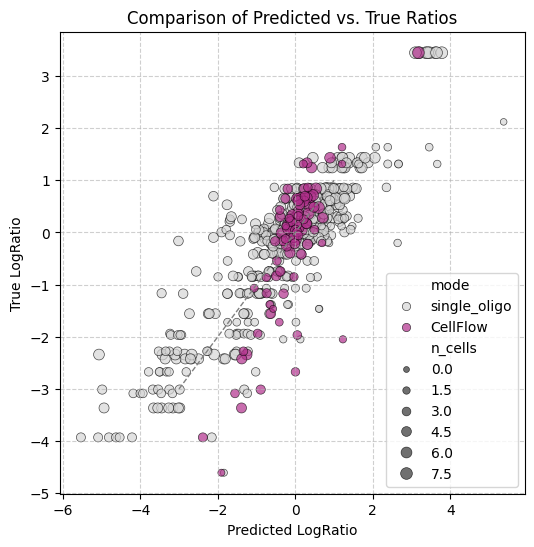

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

color_dict = {"CellFlow": "#B12F8C", "single_oligo": "#D6D6D6"}



# Scatter plot with seaborn
sns.scatterplot(data=df_concat_red, x="logratio_pred", y="logratio_true", size="n_cells", hue="mode", alpha=0.7, edgecolor="k", palette=color_dict)

# Add a diagonal reference line (ideal y = x line)
plt.plot([-3, 1], [-3, 1], linestyle="--", color="gray", linewidth=1)

# Labels and title
plt.xlabel("Predicted LogRatio")
plt.ylabel("True LogRatio")
plt.title("Comparison of Predicted vs. True Ratios")

# Grid and styling
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()


In [95]:
df_concat_red[df_concat_red["mode"]=="CellFlow"][["logratio_true", "logratio_pred"]].corr("pearson").iloc[0,1]

0.7956912840892895

In [96]:
df_concat_red[df_concat_red["mode"]=="single_oligo"][["logratio_true", "logratio_pred"]].corr("pearson").iloc[0,1]

0.8726711779504355

In [97]:
df_concat_red.to_csv(os.path.join(output_dir, f"logfoldchanges_{cond}.csv"))

In [100]:
cond = cond_to_check2
df_concat_red = df_concat[df_concat["condition"]==cond]

df_concat_red["n_cells"] = df_concat_red.apply(lambda x: np.log(df_counts[(df_counts["condition"]==x["condition"])&(df_counts["cell_type_broad"]==x["cell_type_broad_transfer"])]["n_cells"].values[0]+1), axis=1)
df_concat_red = df_concat_red.reset_index()

/tmp/ipykernel_3981988/927753034.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_concat_red["n_cells"] = df_concat_red.apply(lambda x: np.log(df_counts[(df_counts["condition"]==x["condition"])&(df_counts["cell_type_broad"]==x["cell_type_broad_transfer"])]["n_cells"].values[0]+1), axis=1)


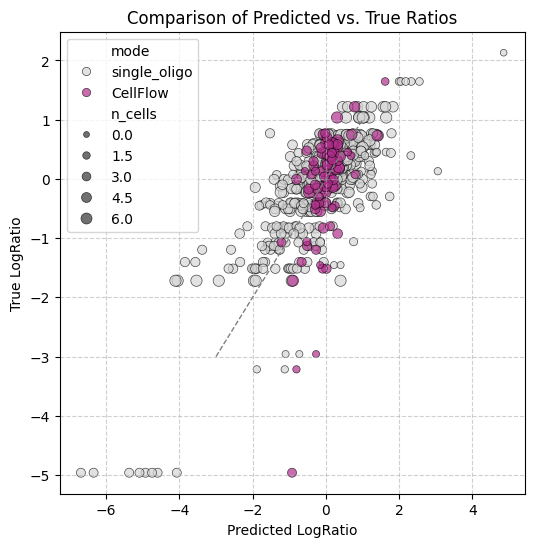

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

color_dict = {"CellFlow": "#B12F8C", "single_oligo": "#D6D6D6"}



# Scatter plot with seaborn
sns.scatterplot(data=df_concat_red, x="logratio_pred", y="logratio_true", size="n_cells", hue="mode", alpha=0.7, edgecolor="k", palette=color_dict)

# Add a diagonal reference line (ideal y = x line)
plt.plot([-3, 1], [-3, 1], linestyle="--", color="gray", linewidth=1)

# Labels and title
plt.xlabel("Predicted LogRatio")
plt.ylabel("True LogRatio")
plt.title("Comparison of Predicted vs. True Ratios")

# Grid and styling
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()


In [102]:
df_concat_red[df_concat_red["mode"]=="CellFlow"][["logratio_true", "logratio_pred"]].corr("pearson").iloc[0,1]

0.5923680556547691

In [103]:
df_concat_red[df_concat_red["mode"]=="CellFlow"][["logratio_true", "logratio_pred"]].corr("pearson").iloc[0,1]
df_concat_red[df_concat_red["mode"]=="single_oligo"][["logratio_true", "logratio_pred"]].corr("pearson").iloc[0,1]

0.8091999888369951

In [104]:
df_concat_red.to_csv(os.path.join(output_dir, f"logfoldchanges_{cond}.csv"))

In [109]:
cond = "cdx4_cdx1a_36"
df_concat_red = df_concat[df_concat["condition"]==cond]

df_concat_red["n_cells"] = df_concat_red.apply(lambda x: np.log(df_counts[(df_counts["condition"]==x["condition"])&(df_counts["cell_type_broad"]==x["cell_type_broad_transfer"])]["n_cells"].values[0]+1), axis=1)
df_concat_red = df_concat_red.reset_index()

/tmp/ipykernel_3981988/1698311488.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_concat_red["n_cells"] = df_concat_red.apply(lambda x: np.log(df_counts[(df_counts["condition"]==x["condition"])&(df_counts["cell_type_broad"]==x["cell_type_broad_transfer"])]["n_cells"].values[0]+1), axis=1)


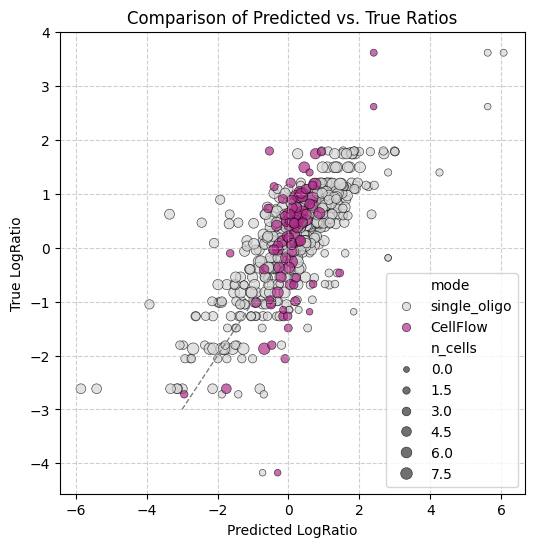

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

color_dict = {"CellFlow": "#B12F8C", "single_oligo": "#D6D6D6"}



# Scatter plot with seaborn
sns.scatterplot(data=df_concat_red, x="logratio_pred", y="logratio_true", size="n_cells", hue="mode", alpha=0.7, edgecolor="k", palette=color_dict)

# Add a diagonal reference line (ideal y = x line)
plt.plot([-3, 1], [-3, 1], linestyle="--", color="gray", linewidth=1)

# Labels and title
plt.xlabel("Predicted LogRatio")
plt.ylabel("True LogRatio")
plt.title("Comparison of Predicted vs. True Ratios")

# Grid and styling
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()


In [111]:
df_concat_red[df_concat_red["mode"]=="CellFlow"][["logratio_true", "logratio_pred"]].corr("pearson").iloc[0,1]


0.6234649081166599

In [112]:
df_concat_red[df_concat_red["mode"]=="single_oligo"][["logratio_true", "logratio_pred"]].corr("pearson").iloc[0,1]

0.7788299472557744

In [113]:
df_concat_red.to_csv(os.path.join(output_dir, f"logfoldchanges_{cond}.csv"))

In [116]:
cond = "phox2a_control_36"
df_concat_red = df_concat[df_concat["condition"]==cond]

df_concat_red["n_cells"] = df_concat_red.apply(lambda x: np.log(df_counts[(df_counts["condition"]==x["condition"])&(df_counts["cell_type_broad"]==x["cell_type_broad_transfer"])]["n_cells"].values[0]+1), axis=1)
df_concat_red = df_concat_red.reset_index()

/tmp/ipykernel_3981988/1052209301.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_concat_red["n_cells"] = df_concat_red.apply(lambda x: np.log(df_counts[(df_counts["condition"]==x["condition"])&(df_counts["cell_type_broad"]==x["cell_type_broad_transfer"])]["n_cells"].values[0]+1), axis=1)


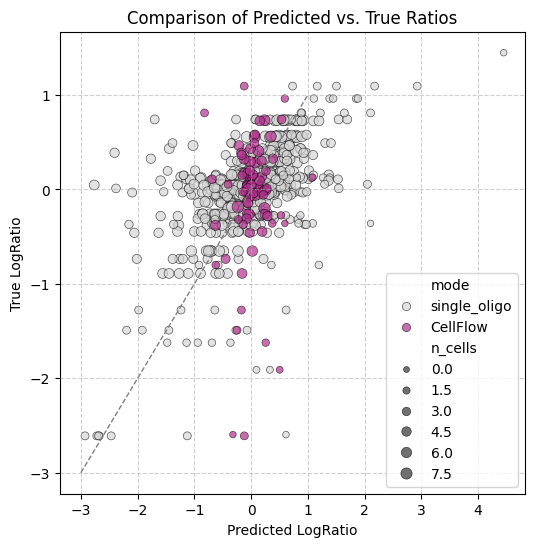

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

color_dict = {"CellFlow": "#B12F8C", "single_oligo": "#D6D6D6"}



# Scatter plot with seaborn
sns.scatterplot(data=df_concat_red, x="logratio_pred", y="logratio_true", size="n_cells", hue="mode", alpha=0.7, edgecolor="k", palette=color_dict)

# Add a diagonal reference line (ideal y = x line)
plt.plot([-3, 1], [-3, 1], linestyle="--", color="gray", linewidth=1)

# Labels and title
plt.xlabel("Predicted LogRatio")
plt.ylabel("True LogRatio")
plt.title("Comparison of Predicted vs. True Ratios")

# Grid and styling
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()


In [118]:
df_concat_red[df_concat_red["mode"]=="CellFlow"][["logratio_true", "logratio_pred"]].corr("pearson").iloc[0,1]


0.12995248276977148

In [119]:
df_concat_red[df_concat_red["mode"]=="single_oligo"][["logratio_true", "logratio_pred"]].corr("pearson").iloc[0,1]

0.5638243718664421

In [120]:
df_concat_red.to_csv(os.path.join(output_dir, f"logfoldchanges_{cond}.csv"))